# 基于图片相似度的图片搜索


## 简要介绍

图片搜索是一种有着广泛的应用场景的深度学习技术的应用，目前，无论是工程图纸的检索，还是互联网上相似图片的搜索，都基于深度学习算法能够实现很好的基于给定图片，检索出跟该图片相似的图片的效果。

本示例简要介绍如何通过飞桨开源框架，实现图片搜索的功能。其基本思路是，先将图片使用卷积神经网络转换为高维空间的向量表示，然后计算两张图片的高维空间的向量表示之间的相似程度(本示例中，我们使用余弦相似度)。在模型训练阶段，其训练目标是让同一类别的图片的相似程度尽可能的高，不同类别的图片的相似程度尽可能的低。在模型预测阶段，对于用户上传的一张图片，会计算其与图片库中图片的相似程度，返回给用户按照相似程度由高到低的图片的列表作为检索的结果。


## 环境设置

本示例基于飞桨开源框架2.0RC版本。

In [13]:
import paddle
import paddle.nn.functional as F
import numpy as np
import random
import matplotlib.pyplot as plt
from PIL import Image
from collections import defaultdict

print(paddle.__version__)

2.0.0-rc0


## 数据集

本示例采用[CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html)数据集。这是一个经典的数据集，由50000张图片的训练数据，和10000张图片的测试数据组成，其中每张图片是一个RGB的长和宽都为32的图片。使用`paddle.vision.datasets.cifar.Cifar10`可以方便的完成数据的下载工作，把数据归一化到`(0, 1.0)`区间内，并提供迭代器供按顺序访问数据。我们会把训练数据和测试数据分别存放在两个`numpy`数组中，供后面的训练和评估来使用。

In [14]:
cifar10_train = paddle.vision.datasets.cifar.Cifar10(mode='train', transform=None)
x_train = np.zeros((50000, 3, 32, 32))
y_train = np.zeros((50000, 1), dtype='int32')

for i in range(len(cifar10_train)):
    train_image, train_label = cifar10_train[i]
    train_image = train_image.reshape((3,32,32 ))
    
    # normalize the data
    x_train[i,:, :, :] = train_image / 255.
    y_train[i, 0] = train_label

y_train = np.squeeze(y_train)

print(x_train.shape)
print(y_train.shape)

(50000, 3, 32, 32)
(50000,)


In [3]:
cifar10_test = paddle.vision.datasets.cifar.Cifar10(mode='test', transform=None)
x_test = np.zeros((10000, 3, 32, 32), dtype='float32')
y_test = np.zeros((10000, 1), dtype='int64')

for i in range(len(cifar10_test)):
    test_image, test_label = cifar10_test[i]
    test_image = test_image.reshape((3,32,32 )) 
   
    # normalize the data
    x_test[i,:, :, :] = test_image / 255.
    y_test[i, 0] = test_label

y_test = np.squeeze(y_test)

print(x_test.shape)
print(y_test.shape)

(10000, 3, 32, 32)
(10000,)


## 数据探索

接下来我们随机从训练数据里找一些图片，浏览一下这些图片。

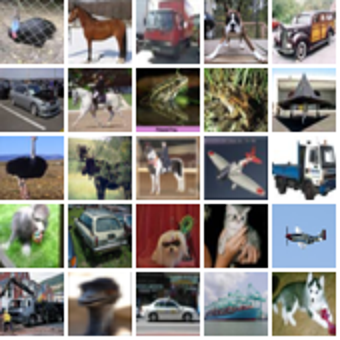

In [4]:
height_width = 32

def show_collage(examples):
    box_size = height_width + 2
    num_rows, num_cols = examples.shape[:2]

    collage = Image.new(
        mode="RGB",
        size=(num_cols * box_size, num_rows * box_size),
        color=(255, 255, 255),
    )
    for row_idx in range(num_rows):
        for col_idx in range(num_cols):
            array = (np.array(examples[row_idx, col_idx]) * 255).astype(np.uint8)
            array = array.transpose(1,2,0)
            collage.paste(
                Image.fromarray(array), (col_idx * box_size, row_idx * box_size)
            )

    collage = collage.resize((2 * num_cols * box_size, 2 * num_rows * box_size))
    return collage

sample_idxs = np.random.randint(0, 50000, size=(5, 5))
examples = x_train[sample_idxs]
show_collage(examples)

## 构建训练数据

图片检索的模型的训练样本跟我们常见的分类任务的训练样本不太一样的地方在于，每个训练样本并不是一个`(image, class)`这样的形式。而是（image0, image1, similary_or_not)的形式，即，每一个训练样本由两张图片组成，而其`label`是这两张图片是否相似的标志位（0或者1）。

很自然的我们能够想到，来自同一个类别的两张图片，是相似的图片，而来自不同类别的两张图片，应该是不相似的图片。

为了能够方便的抽样出相似图片（以及不相似图片）的样本，我们先建立能够根据类别找到该类别下所有图片的索引。

In [5]:
class_idx_to_train_idxs = defaultdict(list)
for y_train_idx, y in enumerate(y_train):
    class_idx_to_train_idxs[y].append(y_train_idx)

class_idx_to_test_idxs = defaultdict(list)
for y_test_idx, y in enumerate(y_test):
    class_idx_to_test_idxs[y].append(y_test_idx)

有了上面的索引，我们就可以为飞桨准备一个读取数据的迭代器。该迭代器每次生成`2 * number of classes`张图片，在CIFAR10数据集中，这会是20张图片。前10张图片，和后10张图片，分别是10个类别中每个类别随机抽出的一张图片。这样，在实际的训练过程中，我们就会有10张相似的图片和90张不相似的图片（前10张图片中的任意一张图片，都与后10张的对应位置的1张图片相似，而与其他9张图片不相似）。


In [6]:
num_classes = 10

def reader_creator(num_batchs):
    def reader():
        iter_step = 0
        while True:
            if iter_step >= num_batchs:
                break
            iter_step += 1
            x = np.empty((2, num_classes, 3, height_width, height_width), dtype=np.float32)
            for class_idx in range(num_classes):
                examples_for_class = class_idx_to_train_idxs[class_idx]
                anchor_idx = random.choice(examples_for_class)
                positive_idx = random.choice(examples_for_class)
                while positive_idx == anchor_idx:
                    positive_idx = random.choice(examples_for_class)
                x[0, class_idx] = x_train[anchor_idx]
                x[1, class_idx] = x_train[positive_idx]
            yield x

    return reader


# num_batchs: how many batchs to generate
def anchor_positive_pairs(num_batchs=100):
    return reader_creator(num_batchs)


In [7]:
pairs_train_reader = anchor_positive_pairs(num_batchs=1000)

拿出第一批次的图片，并可视化的展示出来，如下所示。（这样更容易理解训练样本的构成）

(2, 10, 3, 32, 32)


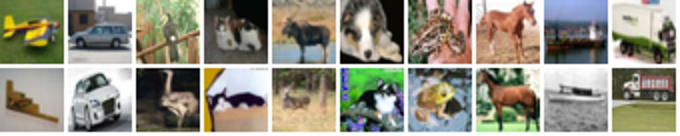

In [8]:
examples = next(pairs_train_reader())
print(examples.shape)
show_collage(examples)

## 把图片转换为高维的向量表示的网络

我们的目标是首先把图片转换为高维空间的表示，然后计算图片在高维空间表示时的相似度。
下面的网络结构用来把一个形状为`(3, 32, 32)`的图片转换成形状为`(8,)`的向量。在有些资料中也会把这个转换成的向量称为`Embedding`，请注意，这与自然语言处理领域的词向量的区别。
下面的模型由三个连续的卷积加一个全局均值池化，然后用一个线性全链接层映射到维数为8的向量空间。为了后续计算余弦相似度时的便利，我们还在最后做了归一化。（即，余弦相似度的分母部分）


In [9]:
class MyNet(paddle.nn.Layer):
    def __init__(self):
        super(MyNet, self).__init__()

        self.conv1 = paddle.nn.Conv2D(in_channels=3, 
                                      out_channels=32, 
                                      kernel_size=(3, 3),
                                      stride=2)
         
        self.conv2 = paddle.nn.Conv2D(in_channels=32, 
                                      out_channels=64, 
                                      kernel_size=(3,3), 
                                      stride=2)       
        
        self.conv3 = paddle.nn.Conv2D(in_channels=64, 
                                      out_channels=128, 
                                      kernel_size=(3,3),
                                      stride=2)
       
        self.gloabl_pool = paddle.nn.AdaptiveAvgPool2D((1,1))

        self.fc1 = paddle.nn.Linear(in_features=128, out_features=8)
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.gloabl_pool(x)
        x = paddle.squeeze(x, axis=[2, 3])
        x = self.fc1(x)
        x = x / paddle.norm(x, axis=1, keepdim=True)
        return x

在模型的训练过程中如下面的代码所示：

- `inverse_temperature`参数起到的作用是让softmax在计算梯度时，能够处于梯度更显著的区域。（可以参考[attention is all you need](https://arxiv.org/abs/1706.03762)中，在点积之后的`scale`操作）。
- 整个计算过程，会先用上面的网络分别计算前10张图片（anchors)的高维表示，和后10张图片的高维表示。然后再用[matmul](https://www.paddlepaddle.org.cn/documentation/docs/zh/api_cn/layers_cn/matmul_cn.html)计算前10张图片分别与后10张图片的相似度。（所以`similarities`会是一个`(10, 10)`的Tensor）。
- 在构造类别标签时，则相应的，可以构造出来0 ~ num_classes的标签值，用来让学习的目标成为相似的图片的相似度尽可能的趋向于1.0，而不相似的图片的相似度尽可能的趋向于-1.0。


In [10]:
def train(model):
    print('start training ... ')
    model.train()

    inverse_temperature = paddle.to_tensor(np.array([1.0/0.2], dtype='float32'))

    epoch_num = 20
    
    opt = paddle.optimizer.Adam(learning_rate=0.0001,
                                parameters=model.parameters())
    
    for epoch in range(epoch_num):
        for batch_id, data in enumerate(pairs_train_reader()):
            anchors_data, positives_data = data[0], data[1]

            anchors = paddle.to_tensor(anchors_data)
            positives = paddle.to_tensor(positives_data)
            
            anchor_embeddings = model(anchors)
            positive_embeddings = model(positives)
            
            similarities = paddle.matmul(anchor_embeddings, positive_embeddings, transpose_y=True) 
            similarities = paddle.multiply(similarities, inverse_temperature)
            
            sparse_labels = paddle.arange(0, num_classes, dtype='int64')

            loss = F.cross_entropy(similarities, sparse_labels)
            
            if batch_id % 500 == 0:
                print("epoch: {}, batch_id: {}, loss is: {}".format(epoch, batch_id, loss.numpy()))
            loss.backward()
            opt.step()
            opt.clear_grad()

model = MyNet()
train(model)

start training ... 
epoch: 0, batch_id: 0, loss is: [2.273315]
epoch: 0, batch_id: 500, loss is: [2.1661842]
epoch: 1, batch_id: 0, loss is: [2.1161895]
epoch: 1, batch_id: 500, loss is: [2.0314116]
epoch: 2, batch_id: 0, loss is: [1.9640319]
epoch: 2, batch_id: 500, loss is: [1.8882437]
epoch: 3, batch_id: 0, loss is: [1.8816122]
epoch: 3, batch_id: 500, loss is: [1.8939931]
epoch: 4, batch_id: 0, loss is: [2.1332495]
epoch: 4, batch_id: 500, loss is: [1.8578304]
epoch: 5, batch_id: 0, loss is: [1.8462454]
epoch: 5, batch_id: 500, loss is: [1.9699743]
epoch: 6, batch_id: 0, loss is: [2.5005558]
epoch: 6, batch_id: 500, loss is: [2.0097346]
epoch: 7, batch_id: 0, loss is: [1.8816965]
epoch: 7, batch_id: 500, loss is: [1.6799539]
epoch: 8, batch_id: 0, loss is: [1.469229]
epoch: 8, batch_id: 500, loss is: [2.241674]
epoch: 9, batch_id: 0, loss is: [1.9045532]
epoch: 9, batch_id: 500, loss is: [2.4102457]
epoch: 10, batch_id: 0, loss is: [1.726363]
epoch: 10, batch_id: 500, loss is: [2.0

## 模型预测 

前述的模型训练训练结束之后，我们就可以用该网络结构来计算出任意一张图片的高维向量表示（embedding)，通过计算该图片与图片库中其他图片的高维向量表示之间的相似度，就可以按照相似程度进行排序，排序越靠前，则相似程度越高。

下面我们对测试集中所有的图片都两两计算相似度，然后选一部分相似的图片展示出来。

In [11]:
near_neighbours_per_example = 10

x_test_t = paddle.to_tensor(x_test)
test_images_embeddings = model(x_test_t)
similarities_matrix = paddle.matmul(test_images_embeddings, test_images_embeddings, transpose_y=True) 

indicies = paddle.argsort(similarities_matrix, descending=True)
indicies = indicies.numpy()

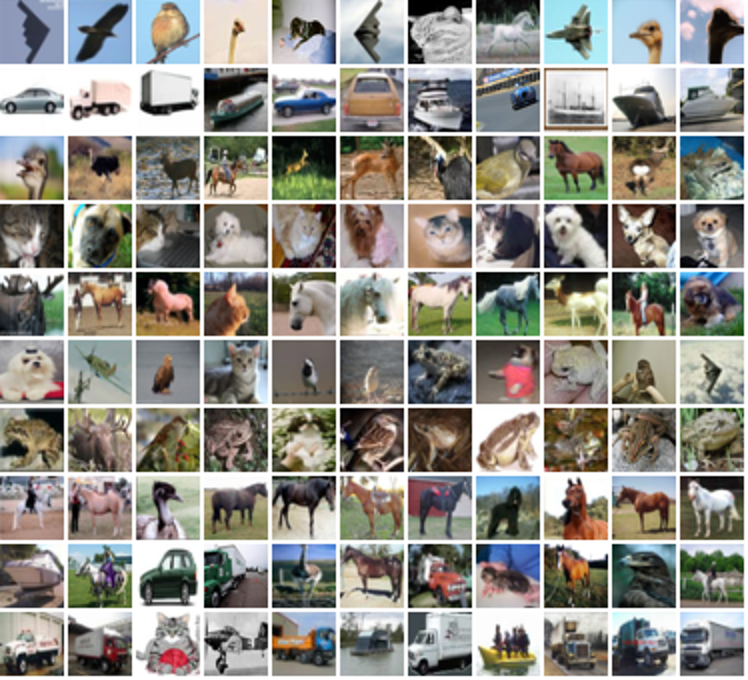

In [16]:
examples = np.empty(
    (
        num_classes,
        near_neighbours_per_example + 1,
        3,
        height_width,
        height_width,
    ),
    dtype=np.float32,
)

for row_idx in range(num_classes):
    examples_for_class = class_idx_to_test_idxs[row_idx]
    anchor_idx = random.choice(examples_for_class)
    
    examples[row_idx, 0] = x_test[anchor_idx]
    anchor_near_neighbours = indicies[anchor_idx][1:near_neighbours_per_example+1]
    for col_idx, nn_idx in enumerate(anchor_near_neighbours):
        examples[row_idx, col_idx + 1] = x_test[nn_idx]

show_collage(examples)

## The end

上面展示的结果当中，每一行里其余的图片都是跟第一张图片按照相似度进行排序相似的图片。但是，你也可以发现，在某些类别上，比如汽车、青蛙、马，可以有不错的效果，但在另外一些类别上，比如飞机，轮船，效果并不是特别好。你可以试着分析这些错误，进一步调整网络结构和超参数，以获得更好的结果。